# Project 2 : Human Activity Recognition

### 프로젝트 제출 가이드
- 제출 기한: 2023년 4월 5일(수) 자정
- 구현 사항:
  - 성능이 잘 나오도록 [3. Feature Extraction](#3.-Feature-Extraction) 셀의 `extract_features` 함수 수정
  - [4. Classifiers](#4.-Classifiers) 셀에 5가지 분류기들을 구현
- 제출 파일: 출력이 포함된 `Project2.ipynb` (여러 번 제출시 마지막 버전을 사용)
- 제출 방법: `X조 ML Project 2` 제목으로 `wisechang1@snu.ac.kr`에 이메일 제출
- 점수 비중: 전체의 30%


### 채점 기준 [총 100점]
1. `LRClassifier`, `LDAClassifier`, `RFClassifier`, `BClassifier`, `SVMClassifier` 각 분류기당 [+20점]
  1. 수행 [+15점] : [5. Cross-validation with Subjects](#5.-Cross-validation-with-Subjects) 셀이 잘 수행되어야 하고, 분류기들은 각각 아래 주어진 방식으로 분류를 수행해야 합니다.
      - `LRClassifier` : Logistic Regression
      - `LDAClassifier` : Linear Discriminant Analysis
      - `RFClassifier` : Random Forest
      - `BClassifier` : Boosting with Decision Tree
      - `SVMClassifier` : Support Vector Machines
  2. 성능 [+5점]
    - 주어지지 않은 별개의 테스트 데이터를 이용해 각 분류기의 성능을 평가합니다. 각 분류기마다 팀별 상대적 성능을 고려해서 0점 ~ 5점 사이로 정해집니다. 팀별 성능을 점수로 변환하는 과정은 아래 코드를 참고해주세요.

    ```python
    import numpy as np
    from scipy import stats

    # Assume there are 5 teams. Example for single classifier.
    macro_f1_score_of_each_team = [0.9, 0.8, 0.5, 0.6, 0.65]

    # 1. Standardize f1 scores
    zscore = stats.zscore(macro_f1_score_of_each_team)
    # 2. Convert standardized f1 scores to 0 ~ 5 points
    score = 5 * (zscore - np.min(zscore)) / (np.max(zscore) - np.min(zscore))

    print(score)  # score = [5, 3.75, 0, 1.25, 1.875]
    ```

2. 띄어쓰기, 주석, Data Plotting 등 실행과 상관없는 부분은 수정이 가능하고, 실행과 관련된 부분은 [3. Feature Extraction](#3.-Feature-Extraction), [4. Classifiers](#4.-Classifiers) 두 부분만 수정하여야 합니다. [-50점]


### 참고 사항
- 이전 성능이 좋았던 팀들의 경우 각 분류기들의 Cross-validation macro F1 score는 0.65 정도 나왔습니다.

---
## 목차
1. [Project Overview](#1.-Project-Overview)
2. [Data Preparation](#2.-Data-Preparation)
3. [Feature Extraction](#3.-Feature-Extraction)
4. [Classifiers](#4.-Classifiers)
5. [Cross-validation with Subjects](#5.-Cross-validation-with-Subjects)

### 1. Project Overview
- 5초간 손목의 가속도계 센서 데이터를 이용해서 그 사람의 행동을 예측하는 분류기를 만듭니다.

<img src="https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-spring/-/raw/master/images/simple_pipeline.png" style='width:70%; margin-bottom:10px'>
<div style='text-align:center; font-weight:bold;'>그림 1. Walking, Running 예제 데이터</div>

### Import libraries

In [3]:
import pickle
from urllib.request import urlopen

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
%matplotlib inline

### 2. Data Preparation
#### 2.1. Data Load
- 각 샘플은 X, Y, Subject로 이루어져 있습니다.
  - X: 가속도계의 3축 데이터
    - (500, 3) 형태의 `np.ndarray`
    - 5초 동안 100Hz로 3축 데이터를 모아 (500, 3) shape를 가지고 있습니다.
  - Y: 실험자의 행동
    - `str`
    - e.g. `walking`, `running`, ...
  - Subject: 해당 샘플을 수집한 실험자의 ID
    - `int`

In [4]:
def load_data(local=True):
    """
    For colab, use local = False.
    It takes a few minutes to download.
    """
    if local:
        DATA_PATH = 'data/train.pkl'
        with open(DATA_PATH, 'rb') as f:
            df = pickle.load(f)
    else:
        DATA_URL = 'https://gitlab.com/machine-learning-course1/ml-project-samsung-2023-spring/-/raw/master/data/train.pkl?inline=false'
        df = pickle.load(urlopen(DATA_URL))

    X        = np.stack(df['Data'])
    Y        = np.stack(df['Motion'])
    Subjects = np.stack(df['Subject'])

    return X, Y, Subjects

In [12]:
X, Y, Subjects = load_data(local=True)

print(f'X: {X.shape}  Y: {Y.shape}  Subjects: {Subjects.shape}')
print(f'Motions: {sorted(set(Y))}')
print(f'Subjects: {sorted(set(Subjects))}')

X: (13940, 500, 3)  Y: (13940,)  Subjects: (13940,)
Motions: ['Nordic walking', 'ascending stairs', 'cycling', 'descending stairs', 'ironing', 'lying', 'rope jumping', 'running', 'sitting', 'standing', 'vacuum cleaning', 'walking']
Subjects: [3, 4, 5, 6, 7, 8, 9]


#### 2.2. Plotting a Data Sample

C:\Users\joonh\AppData\Local\Temp\ipykernel_35908\3131605681.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


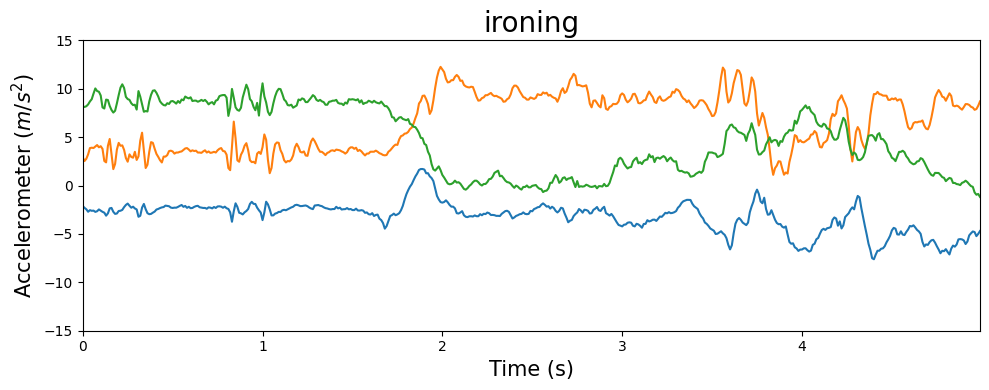

In [13]:
FPS = 100

X_sample, Y_sample = X[0], Y[0]
time_stamps = np.arange(0, len(X_sample)) / FPS


fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(time_stamps, X_sample)

ax.set_title(Y_sample, fontsize=20)
ax.set_xlabel('Time (s)', fontsize=15)
ax.set_ylabel('Accelerometer ($m/s^2$)', fontsize=15)
ax.set_xlim(min(time_stamps), max(time_stamps))
ax.set_ylim(-15, 15)

fig.tight_layout()
fig.show()

### 3. Feature Extraction
#### TODO: `extract_features(X_sample)` 함수 구현
- (500, 3) 크기의 데이터 샘플 하나를 입력받아 특성들을 1D numpy array로 반환합니다.
- 주어진 코드에서는 Time domain의 mean, std 와 Frequency domain의 dominant frequency를 뽑고 있습니다.
- xyz축별 특성 뿐만 아니라 xyz축의 값을 합쳐서 사용해보셔도 좋습니다.
- 어느 정도 성능이 나온 이후에는 Confusion Matrix를 그려보면서 헷갈리는 동작들을 구분할 수 있는 특성들을 추가하면 성능을 높일 수 있습니다.
- 너무 많은 특성들을 사용하실 경우 Cross Validation 결과는 좋지만 Test 결과가 안좋을 수 있습니다.
- 아래 특성들은 Human Activity Recognition에서 많이 사용되는 특성들입니다.
  - Time Domain
    - min, max, amplitude, sum, absolute sum, euclidean norm, mean, absolute mean, mean absolute deviation, variance, standard deviation, zero crossings, auto-correlations, skewness, kurtosis, percentiles, power, root mean square, cross-correlation of axes, ...
  - Frequency Domain
    - energy, entropy, power, spectral centroid, mean, median, standard deviation, dominant frequency, ...

In [14]:
def extract_features(X_sample: np.ndarray) -> np.ndarray:
    """
    Extract features from a single sample

    Parameters
    ----------
    X_sample : array of shape (500, 3)
        100Hz * 5 seconds => 500
        3 axis (x, y, z)  => 3

    Returns
    -------
    features : array with (p,) shape
        Extracted features from X_sample
    """
    assert X_sample.shape == (500, 3)

    #################### TODO: Extract more features ####################
    from scipy import stats, signal
    import numpy as np
    from sklearn.decomposition import PCA
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import RandomForestClassifier ,GradientBoostingClassifier , HistGradientBoostingClassifier
    import xgboost as xgb
    from sklearn.svm import SVC
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from xgboost import XGBClassifier
    from sklearn.experimental import enable_hist_gradient_boosting
    from sklearn.preprocessing import MaxAbsScaler , RobustScaler , PowerTransformer , QuantileTransformer , FunctionTransformer ,StandardScaler

        # Extract time domain features
    X_time = X_sample
    #X_time = np.sign(np.mean(X_sample,axis=0))*X_time
    mean = np.mean(X_time, axis=0)
    mean_abs = np.abs(np.mean(X_time, axis=0))
    max = np.max(X_time, axis=0)
    min = np.max(X_time, axis=0)
    max_min = max-min
    mode = stats.mode(X_time, axis=0)[0][0]
    std = np.std(X_time, axis=0)

    time_lag_atr_x = [1,2,3,4,5,10,20,30,40,50]
    time_lag_atr_y = [1,2,3,4,5,10,20,30,40,50]
    time_lag_atr_z = [1,2,3,4,5,10,20,30,40,50]
    time_lag_atrr_x = np.array([np.corrcoef(X_sample[:-i,0], X_sample[i:,0])[0,1] for i in time_lag_atr_x])
    time_lag_atrr_y = np.array([np.corrcoef(X_sample[:-i,1], X_sample[i:,1])[0,1] for i in time_lag_atr_y])
    time_lag_atrr_z = np.array([np.corrcoef(X_sample[:-i,2], X_sample[i:,2])[0,1] for i in time_lag_atr_z])

    cov_xy = np.cov(X_time[:, 0], X_time[:, 1])[0][1]/(np.std(X_time[:, 0]*np.std(X_time[:, 1])))
    cov_yz = np.cov(X_time[:, 1], X_time[:, 2])[0][1]/(np.std(X_time[:, 1]*np.std(X_time[:, 2])))
    cov_zx = np.cov(X_time[:, 2], X_time[:, 0])[0][1]/(np.std(X_time[:, 2]*np.std(X_time[:, 0])))


    # Extract frequency domain features
    X_fft = np.abs(np.fft.fft(X_time, axis=0))[1:]
    fft_argmax = np.argmax(X_fft[0:250], axis=0)
    fft_mean = np.mean(X_fft, axis=0)
    fft_std = np.std(X_fft, axis=0)

    X_fft_T = np.transpose(X_fft)
    f, Pxx = signal.welch(X_fft_T, nperseg=50, axis = -1)
    psd = Pxx / Pxx.sum(axis=0, keepdims=True)
    psd_aggregation = psd.mean(axis=1)


    # Concatenate features
    features = np.hstack([mean_abs,
                          #mean,
                          std,
                        #   max_min,
                          mode,
                          time_lag_atrr_x,time_lag_atrr_y,time_lag_atrr_z,
                          cov_xy, cov_yz, cov_zx,
                          fft_mean,
                          fft_std,
                          fft_argmax,
                          psd_aggregation
                          ])


    ######################################################################

    assert features.ndim == 1
    return features

In [35]:
# Extract features for multiple samples
X_features = np.array([
    extract_features(X_sample)
    for X_sample in X
])
print(X_features.shape)

(13940, 52)


In [49]:
import seaborn as sns
import pandas as pd

column_name = ['mean_abs_x', 'mean_abs_y', 'mean_abs_z', 
              'std_x', 'std_y', 'std_z', 
              'mode_x', 'mode_y', 'mode_z', 
              'time_lag_attr_x_1', 'time_lag_attr_x_2', 'time_lag_attr_x_3', 'time_lag_attr_x_4', 'time_lag_attr_x_5', 'time_lag_attr_x_10', 'time_lag_attr_x_20', 
              'time_lag_attr_x_30', 'time_lag_attr_x_40', 'time_lag_attr_x_50', 
              'time_lag_attr_y_1', 'time_lag_attr_y_2', 'time_lag_attr_y_3', 'time_lag_attr_y_4', 'time_lag_attr_y_5', 'time_lag_attr_y_10', 'time_lag_attr_y_20', 'time_lag_attr_y_30', 'time_lag_attr_y_40', 'time_lag_attr_y_50', 
              'time_lag_attr_z_1', 'time_lag_attr_z_2', 'time_lag_attr_z_3', 'time_lag_attr_z_4', 'time_lag_attr_z_5', 'time_lag_attr_z_10', 'time_lag_attr_z_20', 'time_lag_attr_z_30', 'time_lag_attr_z_40', 'time_lag_attr_z_50', 
              'cov_xy', 'cov_yz', 'cov_zx', 
              'fft_mean_x', 'fft_mean_y', 'fft_mean_z',
              'fft_std_x', 'fft_std_y', 'fft_std_z', 
              'fft_argmax',
              'psd_aggregation_x', 'psd_aggregation_y', 'psd_aggregation_z']
print(len(column_name))
df = pd.DataFrame(X_features)
df.columns = column_name
df.head()

52


,mean_abs_x,mean_abs_y,mean_abs_z,std_x,std_y,std_z,mode_x,mode_y,mode_z,time_lag_attr_x_1,...,fft_mean_x,fft_mean_y,fft_mean_z,fft_std_x,fft_std_y,fft_std_z,fft_argmax,psd_aggregation_x,psd_aggregation_y,psd_aggregation_z
0,3.190969,6.523282,4.731869,1.569929,2.899136,3.493608,-2.85744,0.978659,0.939963,0.898686,...,24.442906,32.377795,60.391541,74.279353,0.0,0.0,0.0,0.175663,0.517591,0.306746
1,4.019252,7.320525,3.331382,2.026086,2.504183,3.052356,-2.85744,0.988387,0.965992,0.940387,...,19.247629,42.811399,51.181383,65.553824,0.0,1.0,1.0,0.241404,0.498213,0.260383
2,4.602343,8.084341,2.453566,1.899216,2.228465,2.069985,-2.85744,0.987899,0.964345,0.936130,...,13.888066,40.245580,44.719869,44.202195,0.0,0.0,1.0,0.270274,0.539621,0.190105
3,3.245236,7.469662,3.259032,4.198999,2.536588,2.063136,-8.13325,0.996667,0.989434,0.980066,...,16.952797,90.020516,50.669604,42.955021,0.0,2.0,2.0,0.236834,0.538054,0.225111
4,1.184455,6.880556,3.319907,5.782280,2.589469,2.150250,-8.13325,0.998362,0.994685,0.989672,...,18.010008,126.163931,51.644922,44.632490,0.0,1.0,2.0,0.288014,0.559917,0.152069


<Axes: >

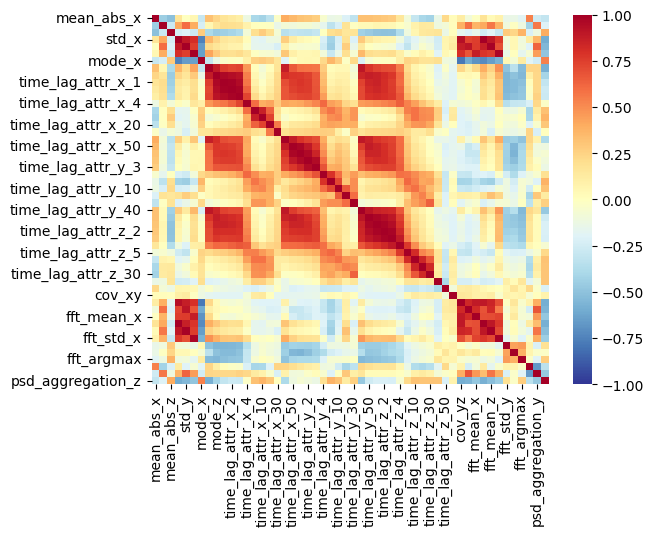

In [54]:
# sns.clustermap(df.corr(), annot = True, cmap='RdYlBu_r', vmin = -1, vmax = 1)
sns.heatmap(df.corr(), cmap='RdYlBu_r', annot = False, vmin=-1, vmax=1)

### 4. Classifiers
#### TODO: `LRClassifier`, `LDAClassifier`, `RFClassifier`, `BClassifier`, `SVMClassifier` 5가지 Classifier 구현
- 아래 링크에서 `sklearn`이 제공하는 전처리기 목록을 확인하실 수 있습니다.
  - [sklearn.preprocessing documentation](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).
- 자세한 튜닝 방법은 `CrossValidation.ipynb`를 참고해주세요.
- `sklearn` 외의 라이브러리를 이용하셔도 됩니다.
- 아래는 KNN을 활용한 예시 Classifier입니다.

```python
# Example KNNClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


KNNClassifier = Pipeline([
    ('scaler', StandardScaler()),
    ('preprocessor', PCA()),
    ('classifier', KNeighborsClassifier(n_neighbors=10)),
])
```

In [17]:
#################### TODO: Implement your own classifiers ####################
from scipy import stats, signal
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier ,GradientBoostingClassifier , HistGradientBoostingClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.preprocessing import MaxAbsScaler , RobustScaler , PowerTransformer , QuantileTransformer , FunctionTransformer ,StandardScaler



LRClassifier = Pipeline([
    ('scaler',PowerTransformer()),
    ('preprocessor', PCA()),
    ('classifier', LogisticRegression(multi_class='ovr', penalty='l2',C=0.1))
])


LDAClassifier = Pipeline([
    ('scaler',PowerTransformer()),
    ('classifier',LinearDiscriminantAnalysis(solver='eigen',shrinkage=0.3))
])

RFClassifier = Pipeline(steps=[('scaler', StandardScaler()), ('preprocessor', PCA()),
                ('classifier',
                 RandomForestClassifier(ccp_alpha=0, max_depth=15,
                                        n_estimators=2000))])

BClassifier = Pipeline([
    ('scaler',RobustScaler()),
    ('classifier',XGBClassifier(objective='multi:softmax',
                                eval_metric='merror',
                                eta=0.3, # learning rate 0~1 클수록 overfit , 업뎃속도빠름
                                num_boost_arround=10, # weak learner 반복수
                                min_child_weight=1, # leaf node에 포함되는 최소 관측치수 작을수록 overfit 0~inf
                                gamma = 0 , #leafnode 의 추가분할을 결정할 최소손실 감소값 클수록 underfit 0~inf
                                max_depth=10, # 트리 최대 깊이 0 설정시 깊이 제한없음 0~inf
                                reg_lambda = 1, #L2 regularization 적용 값 클수록 overfit
                                alpha=0, #L1 Regularization 적용 값 클수록 underfit
                                subsample=0.5,
                                ))
])

SVMClassifier = Pipeline(steps=[('scaler', MaxAbsScaler()), ('preprocessor', PCA()),
                ('classifier', SVC(C=15, gamma=0.005))])

from sklearn.preprocessing import LabelEncoder
Y = LabelEncoder().fit_transform(Y)
##############################################################################

### 5. Cross-validation with Subjects

In [22]:
# for clf in [LRClassifier, LDAClassifier, RFClassifier, BClassifier, SVMClassifier]:
for clf in [LRClassifier]:
    scores = cross_val_score(
        clf,
        X_features, Y,
        groups=Subjects,        # Provide subjects for subject-wise cross-validation
        cv=LeaveOneGroupOut(),  # Subject-wise cross-validation
        scoring='f1_macro',     # Scoring with macro F1 score
        n_jobs=-1,              # Enable multiprocessing
        verbose=10,             # Print processing logs
    )
    print(np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    2.9s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    2.9s remaining:    3.9s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    2.9s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    2.9s remaining:    1.1s


0.6824208982193822


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    3.2s finished


In [24]:
for clf in [LDAClassifier]:
    scores = cross_val_score(
        clf,
        X_features, Y,
        groups=Subjects,        # Provide subjects for subject-wise cross-validation
        cv=LeaveOneGroupOut(),  # Subject-wise cross-validation
        scoring='f1_macro',     # Scoring with macro F1 score
        n_jobs=-1,              # Enable multiprocessing
        verbose=10,             # Print processing logs
    )
    print(np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished


0.772302133923697


In [25]:
for clf in [RFClassifier]:
    scores = cross_val_score(
        clf,
        X_features, Y,
        groups=Subjects,        # Provide subjects for subject-wise cross-validation
        cv=LeaveOneGroupOut(),  # Subject-wise cross-validation
        scoring='f1_macro',     # Scoring with macro F1 score
        n_jobs=-1,              # Enable multiprocessing
        verbose=10,             # Print processing logs
    )
    print(np.mean(scores))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


KeyboardInterrupt: 